In [167]:
import polars as pl

try:
    df = pl.read_csv('/mnt/data01/data/TreeSearch/data/from_organizers/train.csv')
except:
    df = pl.read_csv('data/from_organizers/train.csv')

df = df.to_pandas()

In [168]:
all_lud_rules = df['LudRules'].to_list()
unique_lud_rules = list(set(all_lud_rules))
print(f'Unique LudRules count: {len(unique_lud_rules)}')

unique_agent_names = list(set(df['agent1'].to_list()) | set(df['agent2'].to_list()))
print(f'Unique agent names count: {len(unique_agent_names)}')

Unique LudRules count: 1373
Unique agent names count: 72


In [202]:
from tqdm import tqdm

rules_to_utilities = {
    lud_rules: [[] for _ in range(len(unique_agent_names))]
    for lud_rules in unique_lud_rules
}

for i, row in tqdm(df.iterrows(), total=len(df)):
    lud_rules = row['LudRules']
    agent1 = row['agent1']
    agent2 = row['agent2']
    score = row['utility_agent1']
    rules_to_utilities[lud_rules][unique_agent_names.index(agent1)].append(score)
    rules_to_utilities[lud_rules][unique_agent_names.index(agent2)].append(1 - score)

100%|██████████| 233234/233234 [00:09<00:00, 23628.69it/s]


In [203]:
import numpy as np

rules_to_mean_utilities = {
    lud_rules: [np.mean(scores) for scores in rules_to_utilities[lud_rules]]
    for lud_rules in unique_lud_rules
}

/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [204]:
from sklearn.impute import KNNImputer

all_features = np.array(list(rules_to_mean_utilities.values()))

imputed_features = KNNImputer(n_neighbors=10).fit_transform(all_features)

print(all_features[3])
print(imputed_features[3])

[ 0.2                nan  0.43333333  0.46666667  0.43333333  0.66666667
  0.5                nan  0.83333333 -0.03333333  0.76666667  0.41111111
  0.7         0.45555556  1.1         0.16666667  1.01666667  0.16666667
  0.51666667  1.03333333  0.41666667  0.46666667  0.25        0.47777778
  0.1        -0.23333333  0.7         0.86666667  1.26666667  1.3
  1.03333333  0.61111111  0.36666667  0.7         0.5         0.3
  0.4                nan  0.2         0.38888889  0.35        0.26666667
  0.48666667  0.23333333  0.4         0.3         0.32222222  0.47777778
  0.56666667  0.33333333  1.25        0.21111111 -0.16666667  0.27777778
 -0.26666667  0.5         0.41111111  0.51666667  1.18888889  0.36666667
  0.36666667  0.9         0.61111111  0.36666667  0.9         0.03333333
  0.3         0.76666667  0.71666667  1.          0.76666667  0.7       ]
[ 0.2         0.49055556  0.43333333  0.46666667  0.43333333  0.66666667
  0.5         0.38055556  0.83333333 -0.03333333  0.76666667  0.

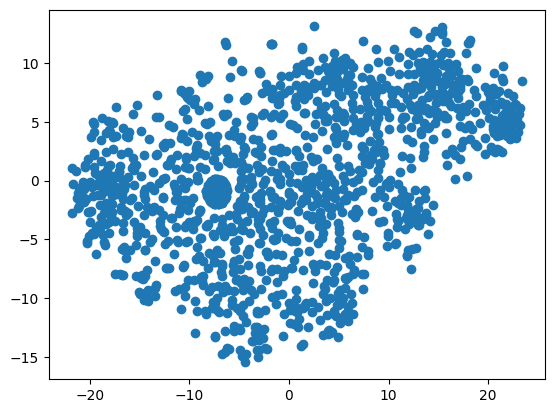

In [206]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

tsne = TSNE(n_components=2, perplexity=50)
X_embedded = tsne.fit_transform(imputed_features)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()

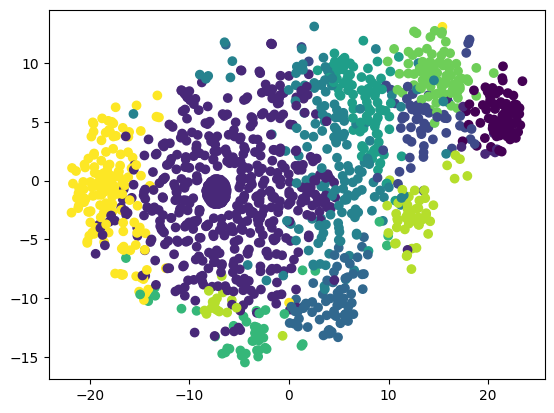

In [207]:
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering, DBSCAN, HDBSCAN, BisectingKMeans

# reduced_features = PCA(n_components=32).fit_transform(imputed_features)

clustering_algo = KMeans(n_clusters=10).fit(imputed_features)
# clustering_algo = BisectingKMeans(n_clusters=16, bisecting_strategy="largest_cluster").fit(imputed_features)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clustering_algo.labels_)
plt.show()

In [208]:
np.bincount(np.array(clustering_algo.labels_))

array([ 71, 580,  60,  73, 162,  93,  46,  82,  65, 141])

In [209]:
cluster_norms = []
non_cluster_norms = []

cluster_nan_counts = []
non_cluster_nan_counts = []
for index, value in enumerate(clustering_algo.labels_):
    if value == 6:
        cluster_norms.append(np.std(imputed_features[index]))
        cluster_nan_counts.append(np.isnan(all_features[index]).sum())
    else:
        non_cluster_norms.append(np.std(imputed_features[index]))
        non_cluster_nan_counts.append(np.isnan(all_features[index]).sum())

print(np.mean(cluster_norms), np.mean(cluster_nan_counts))
print(np.mean(non_cluster_norms), np.mean(non_cluster_nan_counts))

0.4809981791128656 2.5434782608695654
0.2792261994826021 7.782969103240392


In [210]:
import json

lud_rules_to_clusters = {
    lud_rules: int(clustering_algo.labels_[index])
    for index, lud_rules in enumerate(unique_lud_rules)
}

cluster_count = len(set(clustering_algo.labels_))
with open(f'data/lud_rules_to_clusters/{cluster_count}.json', 'w') as output_file:
    json.dump(lud_rules_to_clusters, output_file, indent=4)

In [177]:
from sklearn.metrics import log_loss

dummy_distribution = np.bincount(clustering_algo.labels_) / len(clustering_algo.labels_)
dummy_classifier_predictions = [dummy_distribution for label in clustering_algo.labels_]

print(log_loss(clustering_algo.labels_, dummy_classifier_predictions))

1.937737119084456


In [228]:
rules_to_ungrouped_agent1_utilities = {
    lud_rules: []
    for lud_rules in unique_lud_rules
}

for i, row in tqdm(df.iterrows(), total=len(df)):
    lud_rules = row['LudRules']
    score = row['utility_agent1']

    rules_to_ungrouped_agent1_utilities[lud_rules].append(score)

rules_to_mean_agent1_utilities = {
    lud_rules: np.mean(scores)
    for lud_rules, scores in rules_to_ungrouped_agent1_utilities.items()
}

with open('data/rules_to_mean_agent1_utilities.json', 'w') as output_file:
    json.dump(rules_to_mean_agent1_utilities, output_file, indent=4)

100%|██████████| 233234/233234 [00:09<00:00, 24341.51it/s]


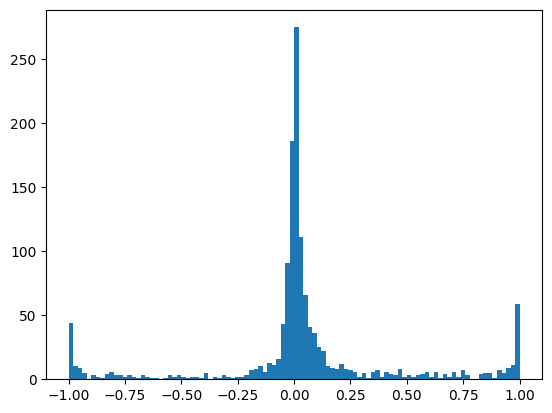

In [230]:
plt.hist(list(rules_to_mean_agent1_utilities.values()), bins=100)
plt.show()

In [231]:
from sklearn.metrics import mean_squared_error

regressor_targets = [rules_to_mean_agent1_utilities[lud_rules] for lud_rules in unique_lud_rules]
dummy_regressor_predictions = [np.mean(regressor_targets) for label in clustering_algo.labels_]

print(mean_squared_error(regressor_targets, dummy_regressor_predictions, squared=False))

0.40375149834281204


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [191]:
rules_to_mean_absolute_agent1_utilities = {
    lud_rules: np.mean(np.abs(scores))
    for lud_rules, scores in rules_to_ungrouped_agent1_utilities.items()
}

with open('data/rules_to_mean_absolute_agent1_utilities.json', 'w') as output_file:
    json.dump(rules_to_mean_absolute_agent1_utilities, output_file, indent=4)

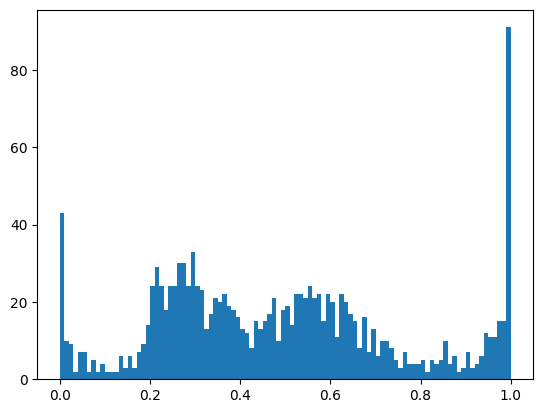

In [192]:
plt.hist(list(rules_to_mean_absolute_agent1_utilities.values()), bins=100)
plt.show()

In [232]:
from sklearn.metrics import mean_squared_error

regressor_targets = [rules_to_mean_absolute_agent1_utilities[lud_rules] for lud_rules in unique_lud_rules]
dummy_regressor_predictions = [np.mean(regressor_targets) for label in clustering_algo.labels_]

print(mean_squared_error(regressor_targets, dummy_regressor_predictions, squared=False))

0.27128768593459995


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [211]:
rules_to_agent1_utilities = {
    lud_rules: [[] for _ in range(len(unique_agent_names))]
    for lud_rules in unique_lud_rules
}
rules_to_agent2_utilities = {
    lud_rules: [[] for _ in range(len(unique_agent_names))]
    for lud_rules in unique_lud_rules
}
rules_to_all_agent_utilities = {
    lud_rules: [[] for _ in range(len(unique_agent_names))]
    for lud_rules in unique_lud_rules
}

for i, row in tqdm(df.iterrows(), total=len(df)):
    lud_rules = row['LudRules']
    agent1 = row['agent1']
    agent2 = row['agent2']
    score = row['utility_agent1']
    rules_to_agent1_utilities[lud_rules][unique_agent_names.index(agent1)].append(score)
    rules_to_agent2_utilities[lud_rules][unique_agent_names.index(agent2)].append(-1 * score)

    rules_to_all_agent_utilities[lud_rules][unique_agent_names.index(agent1)].append(score)
    rules_to_all_agent_utilities[lud_rules][unique_agent_names.index(agent2)].append(-1 * score)

100%|██████████| 233234/233234 [00:10<00:00, 22494.17it/s]


In [212]:
rules_to_mean_agent1_utilities = {
    lud_rules: [np.mean(scores) for scores in rules_to_agent1_utilities[lud_rules]]
    for lud_rules in unique_lud_rules
}

rules_to_mean_agent2_utilities = {
    lud_rules: [np.mean(scores) for scores in rules_to_agent2_utilities[lud_rules]]
    for lud_rules in unique_lud_rules
}

rules_to_mean_all_agent_utilities = {
    lud_rules: [np.mean(scores) for scores in rules_to_all_agent_utilities[lud_rules]]
    for lud_rules in unique_lud_rules
}

full_features = []
for rule, mean_agent1_utilities in rules_to_mean_agent1_utilities.items():
    full_features.append(mean_agent1_utilities + rules_to_mean_agent2_utilities[rule] + rules_to_mean_all_agent_utilities[rule])

full_features = np.array(full_features)

imputed_full_features = KNNImputer(n_neighbors=10).fit_transform(full_features)

/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [215]:
reduced_full_features = PCA(n_components=32).fit_transform(imputed_full_features)

rules_to_reduced_features = {
    rule: list(reduced_full_features[index])
    for index, rule in enumerate(rules_to_mean_agent1_utilities.keys())
}

with open('data/rules_to_pca_utilities.json', 'w') as output_file:
    json.dump(rules_to_reduced_features, output_file, indent=4)

In [218]:
from sklearn.metrics import mean_squared_error

average_reduced_features = np.mean(reduced_full_features, axis=0)

dummy_pca_predictions = [average_reduced_features for _ in reduced_full_features]
dumpy_pda_prediction_score = mean_squared_error(reduced_full_features, dummy_pca_predictions)

print(dumpy_pda_prediction_score)

1.316730869200157
